# 2018-02-16 / FMA sub-sampling mk2

* In case entrofy is too slow / doesn't work out, we'll make a backup sampler
* Requirements:
    * subsample of size N
    * for each instrument, at least K positives

# 2018-03-15 / Updates

* License filtering: CC only
* Sampling: 50/50 from 80/20 per instrument

# 2018-03-26 / Resample

* Sample per instrument category
* No explicit negatives
* Save categorical samples independently

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import gzip

In [3]:
import seaborn as sns

In [4]:
%matplotlib inline

In [56]:
# Filter down to the set with valid licenses

#df_valid = pd.read_csv('/home/bmcfee/data/cc_tracks.csv.gz', usecols=[0])['track_id']
df_valid = pd.read_csv('/home/bmcfee/data/cc_tracks.csv.gz', usecols=[0], nrows=1000000)['track_id']
df_valid = df_valid.apply(lambda x: '{:06d}'.format(x))

In [57]:
valid_set = set(df_valid)

In [58]:
#df = pd.read_csv('/home/bmcfee/data/vggish-likelihoods-a226b3-maxagg10.csv.gz', index_col=0)
df = pd.read_csv('/home/bmcfee/data/vggish-likelihoods-a226b3-maxagg10.csv.gz', nrows=1000000, index_col=0)

In [59]:
df = df.drop([x for x in tqdm(df.index) if x[:6] not in valid_set])

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

In [60]:
df.head(5)

,accordion,bagpipes,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,...,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
000002_0000,0.01542,0.008608,0.010215,0.035007,0.008873,0.00893,0.086853,0.671350,0.021807,0.135010,...,0.006079,0.011073,0.084341,0.015115,0.781432,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0001,0.01542,0.008608,0.010215,0.076214,0.008873,0.00893,0.086853,0.630533,0.021807,0.244505,...,0.006079,0.011073,0.084341,0.015115,0.781432,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0002,0.01542,0.008608,0.010215,0.076214,0.008873,0.00893,0.089177,0.858667,0.021807,0.244505,...,0.006079,0.011073,0.084341,0.015115,0.188291,0.012166,0.025021,0.044818,0.067646,0.999691
000002_0003,0.01542,0.008608,0.010215,0.076214,0.004974,0.00893,0.089177,0.858667,0.012667,0.244505,...,0.003388,0.009051,0.040380,0.009120,0.131694,0.005950,0.014247,0.044818,0.067646,0.999691
000002_0004,0.01542,0.008608,0.009334,0.076214,0.004974,0.00893,0.089177,0.858667,0.012667,0.244505,...,0.003388,0.017866,0.078745,0.009120,0.204007,0.005950,0.014247,0.028634,0.088025,0.999691


# Algorithm
- For each instrument, split at the *QUANTILE* by likelihood
- Skip tracks that have already appeared
- Take *BALANCE* samples uniformly from above the quantile, and *1-BALANCE* from below.
- Handle instruments by increasing order of median likelihood

# UPDATES: 2018-03-26

In [61]:
K = 1000
N = K * 23

#BALANCE = 0.5
#QUANTILE = 0.8
BALANCE = 1.0
QUANTILE = 0.9

In [62]:
dfm = df.median(axis=0)

In [63]:
inst_order = dfm.sort_values().index

In [64]:
inst_order

Index(['mandolin', 'harp', 'clarinet', 'banjo', 'bagpipes', 'accordion',
       'harmonica', 'trombone', 'ukulele', 'cello', 'trumpet', 'flute',
       'saxophone', 'organ', 'mallet_percussion', 'violin', 'piano', 'cymbals',
       'synthesizer', 'bass', 'drums', 'guitar', 'voice'],
      dtype='object')

In [65]:
idx_inst = df[inst_order[0]].sort_values(ascending=False).index

In [66]:
len(idx_inst)

962063

In [67]:
rng = np.random.RandomState(20180326)

In [68]:
from collections import defaultdict

In [96]:
idx_set = {k: set() for k in inst_order}
track_set = set()


N_ABOVE = int(BALANCE * K)
N_BELOW = int(K * (1 - BALANCE))

pos_thresh = int((1 - QUANTILE) * len(idx_inst))

for col in tqdm(inst_order):
    print(col)
    # This gives a descending sort of the instruments by likelihood
    idx_inst = df[col].sort_values(ascending=False).index
    
    # Get the top quantile
    idx_pos = idx_inst[:pos_thresh]

    # Randomly permute
    idx_pos = rng.permutation(idx_pos)
    
    count = 0
    
    # Make a uniform selection within the top 
    for v in idx_pos:
        track, seg = v.split('_', maxsplit=1)
        
        if track not in track_set:
            idx_set[col].add(v)
            track_set.add(track)
            count += 1
        
        if count == N_ABOVE:
            break
            
    # Get the bottom quantile
    #idx_neg = idx_inst[pos_thresh:]

    # Randomly permute
    #idx_neg = rng.permutation(idx_neg)
    
    #count = 0
    
    # Make a uniform selection within the bottom 
    #for v in idx_neg:
    #    track, seg = v.split('_', maxsplit=1)
        
    #    if track not in track_set:
    #        idx_set[col].add(v)
    #        track_set.add(track)
    #        count += 1
        
    #    if count == N_BELOW:
    #        break

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

mandolin
harp
clarinet
banjo
bagpipes
accordion
harmonica
trombone
ukulele
cello
trumpet
flute
saxophone
organ
mallet_percussion
violin
piano
cymbals
synthesizer
bass
drums
guitar
voice



In [97]:
N_ABOVE

1000

In [98]:
dict(idx_set)

{'accordion': {'000254_0107',
  '000314_0087',
  '000520_0023',
  '000738_0010',
  '000828_0066',
  '000896_0010',
  '000926_0001',
  '000967_0054',
  '000969_0125',
  '001024_0070',
  '001059_0085',
  '001328_0269',
  '001357_0007',
  '001424_0000',
  '001437_0127',
  '001598_0002',
  '001715_0016',
  '001746_0033',
  '001791_0018',
  '001879_0209',
  '001983_0262',
  '001994_0011',
  '002075_0062',
  '003319_0235',
  '003567_0001',
  '003608_0040',
  '003626_0123',
  '004178_0070',
  '004417_0107',
  '004541_0002',
  '004600_0070',
  '004833_0142',
  '005000_0012',
  '005309_0026',
  '005348_0167',
  '006654_0195',
  '006655_0183',
  '006724_0012',
  '006755_0054',
  '006778_0094'},
 'bagpipes': {'000148_0126',
  '000151_0034',
  '000169_0067',
  '000171_0045',
  '000174_0027',
  '000177_0027',
  '000179_0075',
  '000236_0003',
  '000281_0346',
  '000294_0053',
  '000297_0240',
  '000316_0053',
  '000318_0009',
  '000347_0144',
  '000348_0102',
  '000351_0083',
  '000366_0114',
  '00

In [108]:
df_sample = df.loc[idx_set['accordion']]

In [109]:
df_sample

,accordion,bagpipes,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,...,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
006778_0094,0.056028,0.030182,0.013181,0.274565,0.020041,0.006085,0.216374,0.960412,0.128699,0.976360,...,0.021004,0.024246,0.088527,0.010836,0.271257,0.005282,0.013528,0.014448,0.231705,0.929875
000520_0023,0.127793,0.023993,0.018696,0.212785,0.034078,0.011272,0.084620,0.463127,0.011403,0.977577,...,0.011783,0.053170,0.068119,0.057008,0.036096,0.065428,0.063054,0.071385,0.107533,0.991585
005348_0167,0.042222,0.007372,0.008095,0.139990,0.015287,0.008386,0.253342,0.898838,0.020774,0.442502,...,0.014118,0.061495,0.230494,0.079757,0.631158,0.031870,0.033104,0.010402,0.112889,0.246582
000896_0010,0.041396,0.016510,0.009858,0.203339,0.012931,0.005209,0.213564,0.989717,0.016520,0.923699,...,0.010170,0.073024,0.111335,0.025140,0.076441,0.010038,0.014518,0.017895,0.104406,0.865012
001328_0269,0.666794,0.008974,0.001691,0.033927,0.006295,0.005402,0.023408,0.381836,0.017630,0.113637,...,0.002222,0.367198,0.304739,0.013553,0.736752,0.010464,0.011394,0.002520,0.041046,0.256928
000314_0087,0.045780,0.005081,0.003802,0.164943,0.010289,0.004946,0.147368,0.922303,0.040457,0.433775,...,0.002894,0.075194,0.219693,0.014838,0.772367,0.010196,0.012753,0.021114,0.056884,0.968580
001983_0262,0.058407,0.003924,0.013125,0.224223,0.016716,0.014200,0.188921,0.504537,0.021904,0.925450,...,0.007391,0.673576,0.334656,0.074852,0.789065,0.040517,0.042939,0.057567,0.049380,0.682133
003319_0235,0.071594,0.011565,0.006103,0.022010,0.005413,0.021278,0.017025,0.356079,0.066053,0.101530,...,0.009524,0.041536,0.232215,0.030022,0.859785,0.008897,0.017314,0.011597,0.051755,0.999198
000828_0066,0.042752,0.010893,0.003128,0.116592,0.016603,0.004682,0.106692,0.978466,0.007320,0.380614,...,0.002885,0.111688,0.221341,0.043994,0.271143,0.057579,0.056710,0.010672,0.161247,0.898313
004600_0070,0.145217,0.003204,0.002407,0.257536,0.012843,0.006071,0.085090,0.570699,0.006217,0.984789,...,0.005373,0.116447,0.315286,0.044047,0.141992,0.006332,0.009228,0.008134,0.169082,0.977692


In [107]:
import json

In [46]:
for inst in idx_set:
    with open('../notebooks/subsample_idx_{}.json'.format(inst), 'w') as fd:
        json.dump(list(idx_set[inst]), fd, indent=2)
#with open('../notebooks/subsample_idx_greedy_balanced.json', 'w') as fd:
#    json.dump(list(idx_set), fd, indent=2)

---
## Figures

In [47]:
Xs = df_sample.values

In [48]:
np.cov(Xs.T)

array([[  6.96254550e-03,   1.45497710e-03,   4.12710597e-04,
         -8.93825531e-04,   1.08590513e-03,   6.19326386e-04,
         -6.23210306e-04,  -3.53338284e-03,   9.17504658e-04,
         -2.46627778e-03,   2.84848454e-03,   1.08697529e-04,
          1.04468146e-04,   3.29697307e-04,   1.88698075e-03,
          1.25071921e-03,   1.92762309e-03,  -2.67024991e-04,
          1.20028381e-03,   1.59591236e-03,   3.93465396e-04,
          6.10405226e-03,  -6.09126200e-04],
       [  1.45497710e-03,   6.15401596e-03,   6.67309089e-05,
         -9.19046570e-04,   4.35996037e-04,   3.56584930e-04,
         -3.03378794e-04,  -1.74967307e-03,   9.78512857e-04,
         -2.31534126e-03,   1.73737747e-03,  -6.17947636e-05,
          3.97963258e-04,   8.26004410e-05,   8.48378161e-04,
          1.47315439e-04,   6.49472504e-04,   6.65037256e-05,
          4.56842625e-04,   9.24793631e-04,  -7.37394724e-05,
          5.03438336e-03,  -3.96409622e-04],
       [  4.12710597e-04,   6.67309089e-05

In [49]:
import matplotlib.pyplot as plt
%matplotlib nbagg

In [50]:
#C = np.cov(Xs.T)

In [51]:
C = df_sample.corr()
Co = df.corr()

<IPython.core.display.Javascript object>


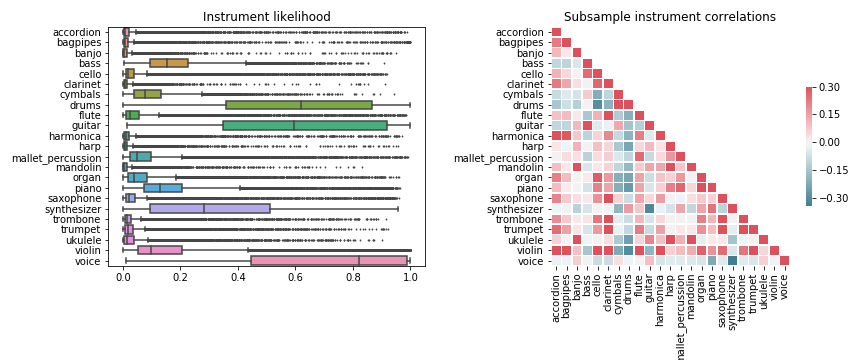

In [54]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
#sns.pointplot(data=df_sample, orient='h', join=False, markers='o', capsize=1, )
sns.boxplot(data=df_sample, orient='h', fliersize=1)

plt.title('Instrument likelihood')
plt.ylim([-0.5, 22.5])
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

mask = np.zeros_like(C, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(C, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Subsample instrument correlations')
plt.tight_layout()

<IPython.core.display.Javascript object>


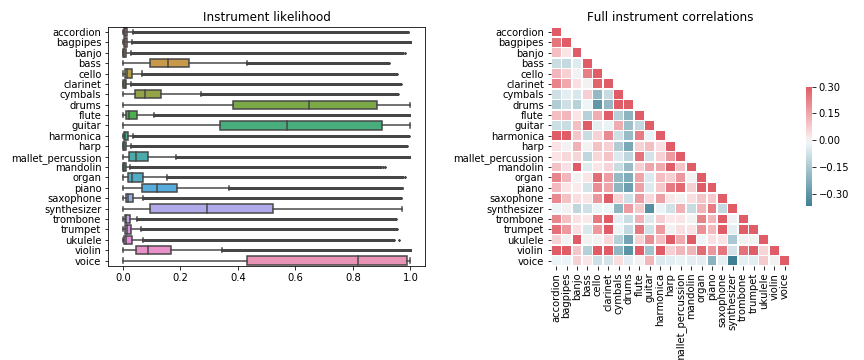

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
#sns.pointplot(data=df, orient='h', join=False, markers='o', capsize=1, )
sns.boxplot(data=df, orient='h', fliersize=1)

plt.title('Instrument likelihood')
plt.ylim([-0.5, 22.5])
plt.gca().invert_yaxis()

plt.subplot(1,2,2)

mask = np.zeros_like(Co, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(Co, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Full instrument correlations')
plt.tight_layout()

---
# Cruft

In [48]:
idx_set = set()
track_set = set()

for col in tqdm(dfm.sort_values().index):

    # This gives a descending sort of the instruments by likelihood
    idx_inst = df[col].sort_values(ascending=False).index
    
    count = 0
    
    # Make a uniform selection within the top 
    for v in idx_inst:
        track, seg = v.split('_', maxsplit=1)
        
        if track in track_set:
            continue
            
        idx_set.add(v)
        track_set.add(track)
        count += 1
        
        if count == K:
            break

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))